In [88]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import drone_env
from tqdm import tqdm
from IPython import display
from SAC_agents import RandomAgent, CriticNN
from collections import namedtuple, deque
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Checking the environment

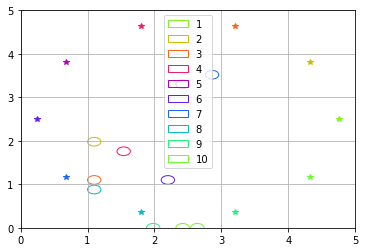

In [138]:
env = drone_env.drones(n_agents = 10, n_obstacles = 0, grid = [5,5], end_formation="O", simplify_zstate = True)
# print(env)
env.show()

In [3]:
# env.reset()

# actions = np.ones([env.n_agents*2,1])*10

# for t in range(4):
#     state = env.step(actions)

# env.show()

In [4]:
# env.plot()

## Simple gradient control. $ u_i = -\nabla _x c_i $

$$ c_i = q|| x_i-x_B ||^2 +  b \sum_{j \in N_i} \log (\frac{\hat{d}_i}{|| x_i-x_j || - r_i -r_j})$$

$$ \nabla _x c_i = 2q (x_i-x_B) - b \sum_{j \in N_i} \frac{1}{|| x_i-x_j || -r_i -r_j} \cdot \frac{x_i-x_j}{|| x_i -x_j ||} $$


100%|██████████| 500/500 [00:01<00:00, 263.98it/s]


Total collisions = 0


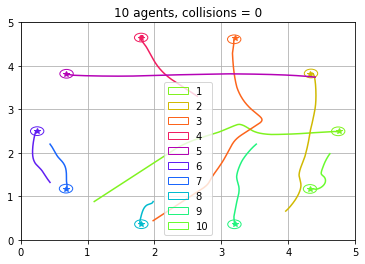

In [144]:
env = drone_env.drones(n_agents = 10, n_obstacles = 0, grid = [5,5], end_formation="O", simplify_zstate = True)


T = 5
times = np.arange(0,T,step=drone_env.dt) + drone_env.dt

total_collisions = 0
reward_history = np.zeros([len(times), env.n_agents])

trajectory = [env.state.copy()]

for iter,t in enumerate(tqdm(times)):
## Simple gradient controller u_i = -grad_i, assuming Nj = V
    state = env.state
    
    # calculate actions based on current state
    actions = drone_env.gradient_control(state,env)

    # Update environment one time step with the actions
    new_state, new_z, rewards, n_collisions, finished = env.step(actions)

    total_collisions += n_collisions
    reward_history[iter,:] = np.mean(rewards)
    trajectory.append(new_state.copy())

# print(env.trajectory[-1])
print(f"Total collisions = {total_collisions}")
env.plot(trajectory)

In [57]:
# env.animate(frame_time = 0.05, frames = 30)


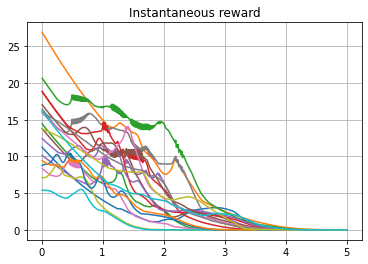

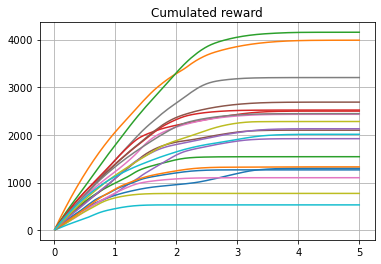

In [58]:
plt.plot(times,-reward_history);
plt.grid(True);
plt.title("Instantaneous reward")
plt.show()

cumulated_reward = np.cumsum(reward_history,0)

plt.plot(times,-cumulated_reward);
plt.grid(True);
plt.title("Cumulated reward")  
plt.show()

TypeError: can't multiply sequence by non-int of type 'float'